In [ ]:
# @title
import numpy as np

def delta_series_step_period_2L(L: float, K: int):
    """
    Unwindowed delta-series in frequency for the period-2L step: 1 on [-L,0], 0 on (0,L].
    Returns svals=ω_k and cvals=F_k for k=-K..K under g(s)=(1/2π)∫F(ω)e^{iω s}dω.
    """
    ks = np.arange(-K, K+1, dtype=int)
    omega = (ks * np.pi) / L
    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = np.pi
        elif k % 2 != 0:          # odd k
            F[i] = 2j / k
        else:
            F[i] = 0.0
    return omega, F, ks

def apply_window(ks, F, kind="lanczos", p=1):
    """
    Apply a harmonic taper to reduce Gibbs. Modifies amplitudes F_k -> w_k * F_k.
      kind = "lanczos" : w_k = sinc(k/(K+1))^p  (Lanczos σ, p>=1)
           = "fejer"   : w_k = 1 - |k|/(K+1)    (Cesàro/Fejér)
           = None/""   : no window
    """
    K = (len(ks) - 1) // 2
    if not kind:
        return F
    w = np.ones_like(F, dtype=float)
    if kind.lower().startswith("lanczos"):
        # np.sinc(x) = sin(pi x)/(pi x)
        w = np.sinc(ks / (K + 1)) ** p
    elif kind.lower().startswith("fejer"):
        w = 1.0 - np.abs(ks) / (K + 1)
        w[w < 0] = 0.0
    return w * F

def reconstruct_from_spikes(s, L, ks, F):
    """g(s) ≈ (1/2π) * Σ_k F_k e^{i (kπ/L) s}."""
    s = np.asarray(s, float)
    omega = (ks * np.pi) / L
    series = np.zeros_like(s, dtype=complex)
    for ok, Fk in zip(omega, F):
        series += Fk * np.exp(1j * ok * s)
    return (series / (2.0 * np.pi)).real



def step_spikes_period_2L(L: float,
                          K: int,
                          A: float = 1.0,
                          window: str | None = "lanczos",
                          p: int = 1,
                          drop_zeros: bool = True,
                          eps: float = 1e-15):
    """
    Return (svals, cvals) for the 2L-periodic step:
        g(s) = A on [-L, 0] mod 2L, and 0 on (0, L] mod 2L.
    Fourier spikes at ω_k = k*pi/L with weights F_k (delta weights).

    Parameters
    ----------
    L : float         # half-period
    K : int           # include k = -K..K
    A : float         # amplitude of the step
    window : {"lanczos","fejer",None}  # harmonic taper (Lanczos σ or Fejér)
    p : int           # power for Lanczos σ (p=1 is classic)
    drop_zeros : bool # drop weights that are exactly/near zero (even k)
    eps : float       # threshold for dropping near-zero weights

    Returns
    -------
    svals : np.ndarray (float)   # ω_k = k*pi/L
    cvals : np.ndarray (complex) # F_k (delta weights at ω_k)
    ks    : np.ndarray (int)     # harmonic indices (for reference)
    """
    ks = np.arange(-K, K+1, dtype=int)
    omega = (ks * np.pi) / L

    # Unwindowed weights: F_0 = 2π * (A/2) = Aπ; F_k = 2π * (iA/(kπ)) for odd k, else 0
    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = A * np.pi
        elif k % 2 != 0:           # odd k
            F[i] = (2j * A) / k
        else:
            F[i] = 0.0

    # Apply optional taper
    if window:
        Kmax = (len(ks) - 1) // 2
        if window.lower().startswith("lanczos"):
            w = np.sinc(ks / (Kmax + 1)) ** p          # Lanczos σ
        elif window.lower().startswith("fejer"):
            w = 1.0 - np.abs(ks) / (Kmax + 1)          # Fejér/Cesàro
            w[w < 0] = 0.0
        else:
            w = np.ones_like(ks, dtype=float)
        F = w * F

    # Optionally drop exact/near zeros (all even k except 0; and any windowed ~0)
    if drop_zeros:
        keep = np.abs(F) > eps
        ks, omega, F = ks[keep], omega[keep], F[keep]

    # Your naming:
    svals = omega
    cvals = F
    return svals, cvals, ks


def fourier_function_factory(ck, wk, phik):
    """
    Build f(x) = sum_k c_k * exp(i*(wk*x + phik))
    - ck: Fourier coefficients (complex or real), shape (K,)
    - wk: angular frequencies (float), shape (K,)
    - phik: optional phases (float), shape (K,), defaults to 0
    Returns: callable f(x_array) -> complex ndarray broadcast over x_array
    """
    ck = np.asarray(ck, dtype=complex)
    wk = np.asarray(wk, dtype=float)
    if phik is None:
        phik = np.zeros_like(wk, dtype=float)
    else:
        phik = np.asarray(phik, dtype=float)
    assert ck.shape == wk.shape == phik.shape, "ck, wk, phik must have the same shape"

    def f(x) -> np.ndarray:
        x = np.asarray(x, dtype=float)[..., None]         # shape (..., 1)
        phase = wk[None, :] * x + phik[None, :]           # broadcast to (..., K)
        return np.sum(ck[None, :] * np.exp(1j * phase), axis=-1) / (2.0 * np.pi)  # shape (...,)
    return f



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- Parameters ---
L = 1.0
K = 100
A = 1.0
window = "lanczos"
p = 1

# --- Step 1: Get Fourier spikes and reconstruct ---
svals, cvals, ks = step_spikes_period_2L(L=L, K=K, A=A, window=window, p=p)
s = np.linspace(-2*L, 2*L, 4000)
g_reconstructed = reconstruct_from_spikes(s, L, ks, cvals)

# --- Step 2: Split left/right around s=0 ---
left_mask = s < 0
right_mask = s > 0
s_left, g_left = s[left_mask], g_reconstructed[left_mask]
s_right, g_right = s[right_mask], g_reconstructed[right_mask]

# --- Step 3: Find last local maximum near y≈1 before s=0 ---
peaks, _ = find_peaks(g_left)
last_peak_idx = peaks[-1] if len(peaks) > 0 else None

# After that peak, find first index where g(s) < 1 (actually drops below plateau)
s_leave = np.nan
if last_peak_idx is not None:
    post_peak = np.arange(last_peak_idx, len(g_left))
    below_one = post_peak[g_left[post_peak] < 1.0]
    if len(below_one) > 0:
        s_leave = s_left[below_one[0]]

# --- Step 4: Find first point after s=0 where it reaches near 0 (say <0.01)
idx_right = np.where(g_right < 0.01 * A)[0]
s_touch = s_right[idx_right[0]] if len(idx_right) > 0 else np.nan

# --- Step 5: Plot ---
plt.figure(figsize=(8, 4))
plt.plot(s, g_reconstructed, label=f"Fourier reconstruction (K={K}, window={window})", color='C0')
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.axhline(A, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

# Draw detected lines
plt.axvline(s_leave, color='r', linestyle='--', label=f"Leaves y=1 after wiggle (s={s_leave:.5f})")
plt.axvline(s_touch, color='orange', linestyle='--', label=f"Touches y=0 (s={s_touch:.5f})")

plt.title("Reconstructed Periodic Step Function g(s)")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.xlim(-5, 5)

plt.show()

print(f"Leaves y=1 ≈ {s_leave}")
print(f"Touches y=0 ≈ {s_touch}")


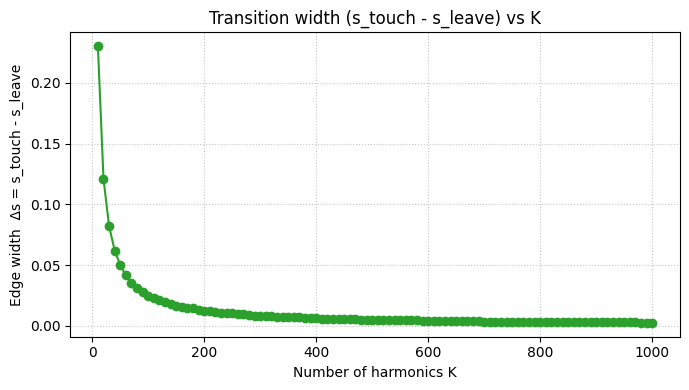

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def transition_width(L=1.0, K=100, A=1.0, window="lanczos", p=1):
    """Compute s_touch - s_leave for given K."""
    # Fourier spikes and reconstruction
    svals, cvals, ks = step_spikes_period_2L(L=L, K=K, A=A, window=window, p=p)
    s = np.linspace(-L, L, 4000)
    g = reconstruct_from_spikes(s, L, ks, cvals)

    # Split around s=0
    left_mask = s < 0
    right_mask = s > 0
    s_left, g_left = s[left_mask], g[left_mask]
    s_right, g_right = s[right_mask], g[right_mask]

    # --- left side: find last wiggle peak near y=1 ---
    peaks, _ = find_peaks(g_left)
    s_leave = np.nan
    if len(peaks) > 0:
        last_peak_idx = peaks[-1]
        post_peak = np.arange(last_peak_idx, len(g_left))
        below_one = post_peak[g_left[post_peak] < 1.0]
        if len(below_one) > 0:
            s_leave = s_left[below_one[0]]

    # --- right side: first point near y=0 ---
    idx_right = np.where(g_right < 0.01 * A)[0]
    s_touch = s_right[idx_right[0]] if len(idx_right) > 0 else np.nan

    # --- return difference ---
    if np.isnan(s_leave) or np.isnan(s_touch):
        return np.nan
    else:
        return s_touch - s_leave

# --- Sweep over different K values ---
K_values = np.arange(10, 1001, 10)
widths = [transition_width(L=1.0, K=K, A=1.0, window="lanczos", p=1) for K in K_values]

# --- Plot ---
plt.figure(figsize=(7,4))
plt.plot(K_values, widths, marker='o', color='C2')
plt.title("Transition width (s_touch - s_leave) vs K")
plt.xlabel("Number of harmonics K")
plt.ylabel("Edge width  Δs = s_touch - s_leave")
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


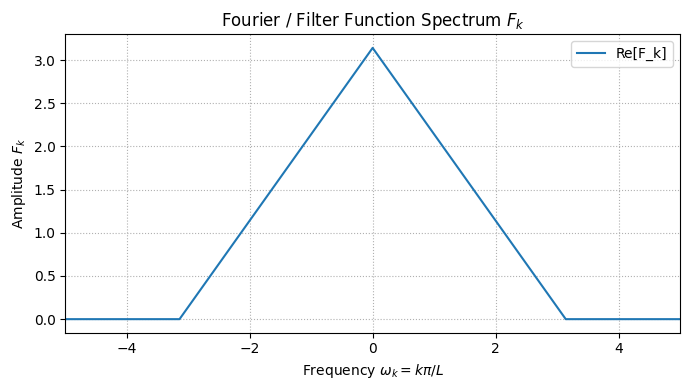

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(svals, np.real(cvals), label='Re[F_k]', color='C0')
#plt.plot(svals, np.imag(cvals), label='Im[F_k]', color='C1')
plt.title("Fourier / Filter Function Spectrum $F_k$")
plt.xlabel(r"Frequency $\omega_k = k\pi/L$")
plt.ylabel(r"Amplitude $F_k$")
plt.grid(True, linestyle=':')
plt.xlim(-5,5)
plt.legend()
plt.tight_layout()
plt.show()


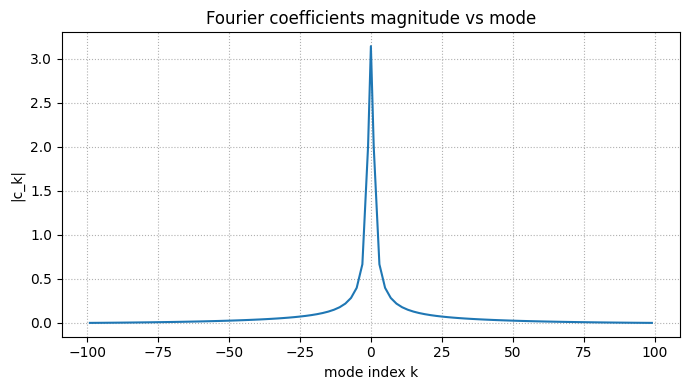

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(ks, np.abs(cvals))
plt.xlabel("mode index k")
plt.ylabel(r"|c_k|")
plt.title("Fourier coefficients magnitude vs mode")
plt.grid(True, linestyle=":")
plt.tight_layout()

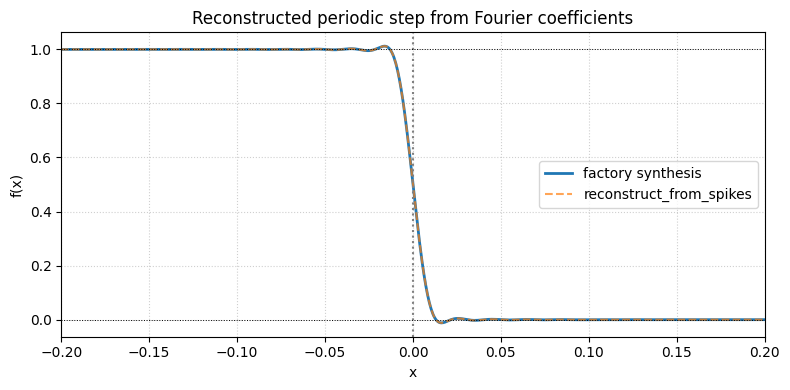

In [ ]:
# 1) Build discrete Fourier modes for the step
L, K, A = 1.0, 100, 1.0
w_k, c_k, ks = step_spikes_period_2L(L=L, K=K, A=A, window="lanczos", p=1)

# 2) Make the synthesis function f(x) from (c_k, w_k)
f = fourier_function_factory(c_k, w_k, phik=None)  # phases default to 0

# 3) Evaluate on an x-grid and plot
x = np.linspace(-L, L, 4000)
g_from_factory = f(x).real                         # real signal
g_from_helper  = reconstruct_from_spikes(x, L, ks, c_k)  # cross-check

plt.figure(figsize=(8,4))
plt.plot(x, g_from_factory, label="factory synthesis", lw=2)
plt.plot(x, g_from_helper, "--", label="reconstruct_from_spikes", alpha=0.7)
plt.axvline(0, color="gray", ls=":")
plt.axhline(0, color="k", ls=":", lw=0.7)
plt.axhline(A, color="k", ls=":", lw=0.7)
plt.xlim(-0.2, 0.2)  # zoom near the jump if you like
plt.title("Reconstructed periodic step from Fourier coefficients")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True, ls=":", alpha=0.6)
plt.tight_layout()
plt.show()


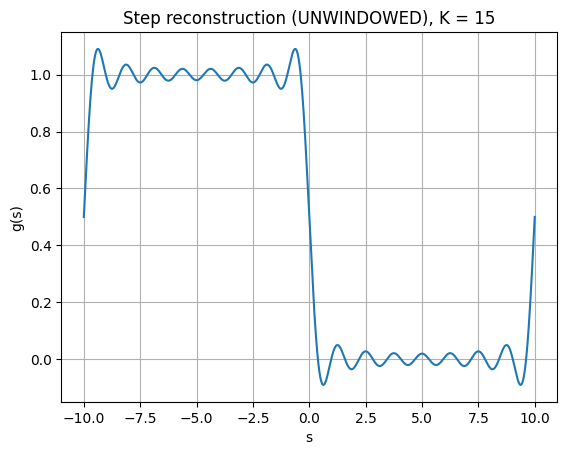

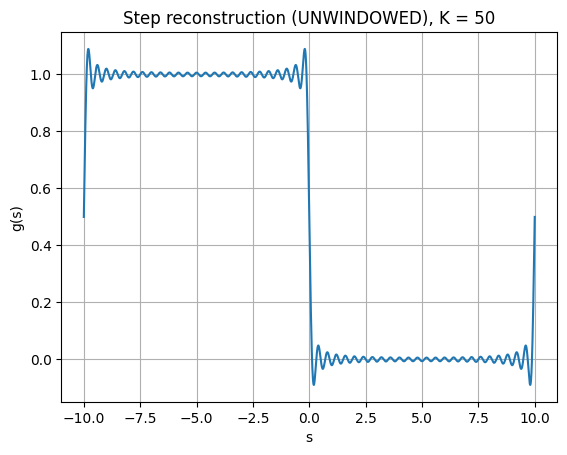

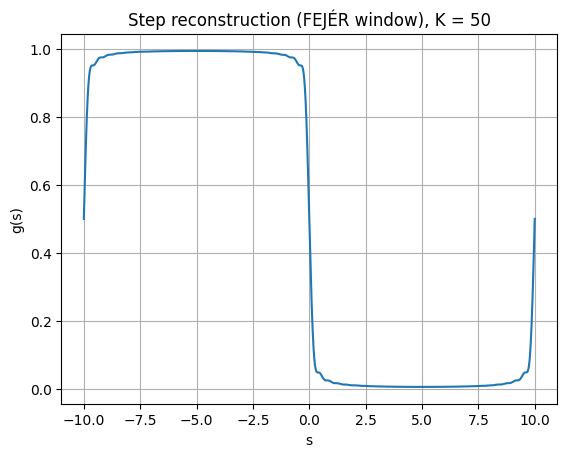

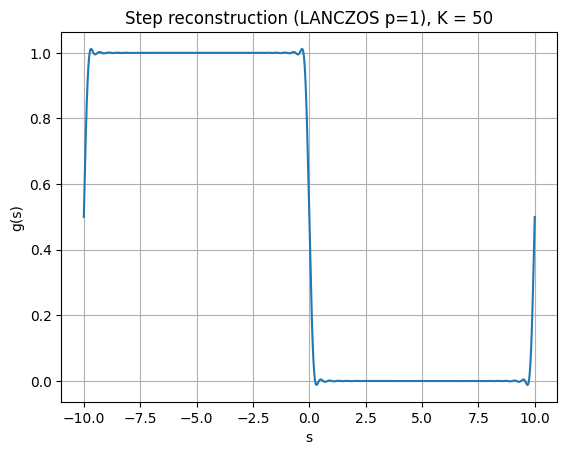

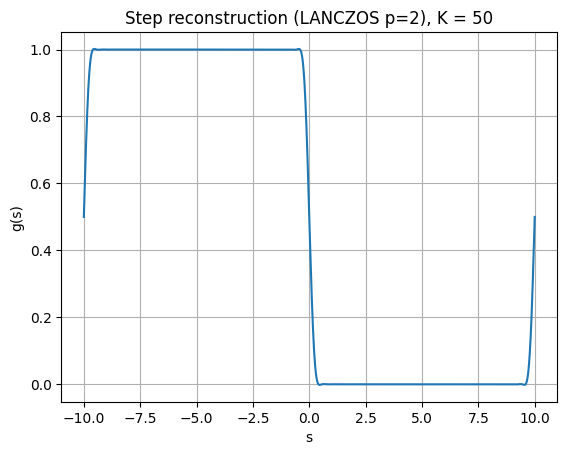

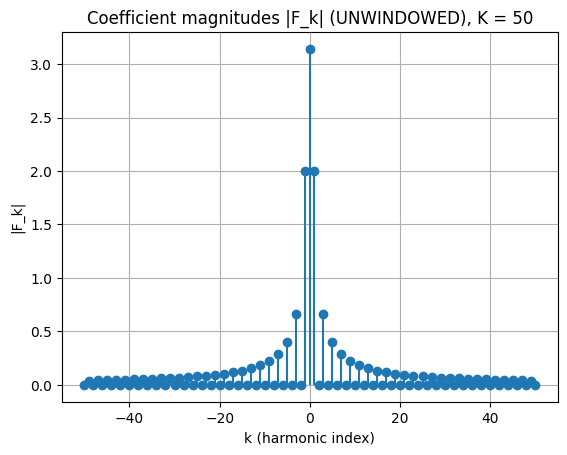

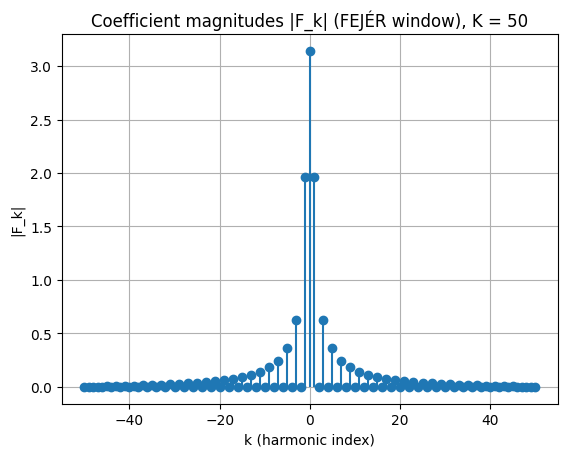

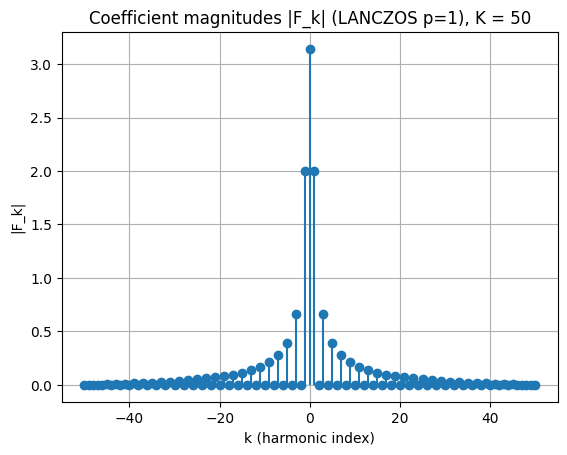

In [ ]:
# Step-by-step visual walkthrough of the Fourier step construction

import numpy as np
import matplotlib.pyplot as plt

# ---------- Functions from your snippet (lightly reorganized) ----------
def delta_series_step_period_2L(L: float, K: int):
    ks = np.arange(-K, K+1, dtype=int)
    omega = (ks * np.pi) / L
    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = np.pi
        elif k % 2 != 0:          # odd k
            F[i] = 2j / k
        else:
            F[i] = 0.0
    return omega, F, ks

def apply_window(ks, F, kind="lanczos", p=1):
    K = (len(ks) - 1) // 2
    if not kind:
        return F
    w = np.ones_like(F, dtype=float)
    if kind.lower().startswith("lanczos"):
        w = np.sinc(ks / (K + 1)) ** p
    elif kind.lower().startswith("fejer"):
        w = 1.0 - np.abs(ks) / (K + 1)
        w[w < 0] = 0.0
    return w * F

def reconstruct_from_spikes(s, L, ks, F):
    s = np.asarray(s, float)
    omega = (ks * np.pi) / L
    series = np.zeros_like(s, dtype=complex)
    for ok, Fk in zip(omega, F):
        series += Fk * np.exp(1j * ok * s)
    return (series / (2.0 * np.pi)).real

def step_spikes_period_2L(L: float,
                          K: int,
                          A: float = 1.0,
                          window: str | None = "lanczos",
                          p: int = 1,
                          drop_zeros: bool = True,
                          eps: float = 1e-15):
    ks = np.arange(-K, K+1, dtype=int)
    omega = (ks * np.pi) / L

    F = np.zeros_like(omega, dtype=complex)
    for i, k in enumerate(ks):
        if k == 0:
            F[i] = A * np.pi
        elif k % 2 != 0:           # odd k
            F[i] = (2j * A) / k
        else:
            F[i] = 0.0

    if window:
        Kmax = (len(ks) - 1) // 2
        if window.lower().startswith("lanczos"):
            w = np.sinc(ks / (Kmax + 1)) ** p
        elif window.lower().startswith("fejer"):
            w = 1.0 - np.abs(ks) / (Kmax + 1)
            w[w < 0] = 0.0
        else:
            w = np.ones_like(ks, dtype=float)
        F = w * F

    if drop_zeros:
        keep = np.abs(F) > eps
        ks, omega, F = ks[keep], omega[keep], F[keep]

    svals = omega
    cvals = F
    return svals, cvals, ks

def fourier_function_factory(ck, wk, phik):
    ck = np.asarray(ck, dtype=complex)
    wk = np.asarray(wk, dtype=float)
    if phik is None:
        phik = np.zeros_like(wk, dtype=float)
    else:
        phik = np.asarray(phik, dtype=float)
    assert ck.shape == wk.shape == phik.shape, "ck, wk, phik must have the same shape"
    def f(x) -> np.ndarray:
        x = np.asarray(x, dtype=float)[..., None]
        phase = wk[None, :] * x + phik[None, :]
        return np.sum(ck[None, :] * np.exp(1j * phase), axis=-1) / (2.0 * np.pi)
    return f

# ---------- Parameters for the demo ----------
L = 10.0
s_grid = np.linspace(-L, L, 3000)

# ---------- 1) Raw (unwindowed) reconstruction with small K ----------
K_small = 15
omega_small, F_small, ks_small = delta_series_step_period_2L(L, K_small)
g_small = reconstruct_from_spikes(s_grid, L, ks_small, F_small)

plt.figure()
plt.plot(s_grid, g_small)
plt.title("Step reconstruction (UNWINDOWED), K = 15")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.grid(True)
plt.show()

# ---------- 2) Raw (unwindowed) with larger K to show sharpening & Gibbs ----------
K_med = 50
omega_med, F_med, ks_med = delta_series_step_period_2L(L, K_med)
g_med = reconstruct_from_spikes(s_grid, L, ks_med, F_med)

plt.figure()
plt.plot(s_grid, g_med)
plt.title("Step reconstruction (UNWINDOWED), K = 50")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.grid(True)
plt.show()

# ---------- 3) Apply Fejér window at K=50 ----------
F_med_fejer = apply_window(ks_med, F_med, kind="fejer", p=1)
g_med_fejer = reconstruct_from_spikes(s_grid, L, ks_med, F_med_fejer)

plt.figure()
plt.plot(s_grid, g_med_fejer)
plt.title("Step reconstruction (FEJÉR window), K = 50")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.grid(True)
plt.show()

# ---------- 4) Apply Lanczos window (p=1) at K=50 ----------
F_med_lanczos = apply_window(ks_med, F_med, kind="lanczos", p=1)
g_med_lanczos = reconstruct_from_spikes(s_grid, L, ks_med, F_med_lanczos)

plt.figure()
plt.plot(s_grid, g_med_lanczos)
plt.title("Step reconstruction (LANCZOS p=1), K = 50")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.grid(True)
plt.show()

# ---------- 5) Stronger Lanczos (p=2) at K=50 ----------
F_med_lanczos2 = apply_window(ks_med, F_med, kind="lanczos", p=2)
g_med_lanczos2 = reconstruct_from_spikes(s_grid, L, ks_med, F_med_lanczos2)

plt.figure()
plt.plot(s_grid, g_med_lanczos2)
plt.title("Step reconstruction (LANCZOS p=2), K = 50")
plt.xlabel("s")
plt.ylabel("g(s)")
plt.grid(True)
plt.show()

# ---------- 6) Coefficient magnitudes vs harmonic index (unwindowed vs windowed) ----------
plt.figure()
plt.stem(ks_med, np.abs(F_med), basefmt=" ")
plt.title("Coefficient magnitudes |F_k| (UNWINDOWED), K = 50")
plt.xlabel("k (harmonic index)")
plt.ylabel("|F_k|")
plt.grid(True)
plt.show()

plt.figure()
plt.stem(ks_med, np.abs(F_med_fejer), basefmt=" ")
plt.title("Coefficient magnitudes |F_k| (FEJÉR window), K = 50")
plt.xlabel("k (harmonic index)")
plt.ylabel("|F_k|")
plt.grid(True)
plt.show()

plt.figure()
plt.stem(ks_med, np.abs(F_med_lanczos), basefmt=" ")
plt.title("Coefficient magnitudes |F_k| (LANCZOS p=1), K = 50")
plt.xlabel("k (harmonic index)")
plt.ylabel("|F_k|")
plt.grid(True)
plt.show()

